In [160]:
import numpy as np
import os
import pandas as pd
import shutil
from pathlib import Path
from collections import defaultdict
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import random
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Project Outline

In this project, we use the dataset from [Kaggle: Chest X-Ray Pneumonia](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) to develop a model that detects **pneumonia in chest X-ray images**. We did:

##### 1. Data Loading & Exploration
- Download and explore the dataset.
- Rebalance the data using custom code and `train_test_split` from `sklearn`.

##### 2. Preprocessing & Visualization
- Visualize representative image samples.
- Apply preprocessing steps including:
  - Grayscale conversion
  - Resizing
  - Normalization

##### 3. Classical Machine Learning
- Flatten the full-resolution images and use them as feature vectors.
- Train the following models:
  - Logistic Regression
  - Support Vector Machine (SVM)
  - Random Forest

##### 4. Deep Learning Models
- Train a custom-built **Convolutional Neural Network (CNN)** from scratch.
- Apply **transfer learning** using **DenseNet121**:
  - With frozen convolutional base (feature extraction)
  - With full fine-tuning for domain-specific adaptation

##### 5. Results & Discussion
- Evaluate all models using F1-score, confusion matrices, and performance plots.
- Discuss the trade-offs between classical ML and deep learning approaches in the context of medical image classification.


In order for the notebook to work seamlessly the folder has to be structured in the following way:

```
.
├── chest_xray/
│   ├── chest_xray/
│   ├── train/
│   ├── test/
│   └── val/
└── notebook.ipynb
```

In [81]:
DATA_DIR = 'chest_xray/chest_xray'
TEST_DIR = os.path.join(DATA_DIR, 'test')
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')

In [82]:
print(os.listdir(TRAIN_DIR))



['.DS_Store', 'PNEUMONIA', 'NORMAL']


In [83]:
print("Normal Training samples: ", len(os.listdir(os.path.join(TRAIN_DIR, 'NORMAL'))))
print("Pneumonia Training samples: ", len(os.listdir(os.path.join(TRAIN_DIR, 'PNEUMONIA'))))
print("Normal Test samples: ", len(os.listdir(os.path.join(TEST_DIR, 'NORMAL'))))
print("Pneumonia Test samples: ", len(os.listdir(os.path.join(TEST_DIR, 'PNEUMONIA'))))
print("Normal Validation samples: ", len(os.listdir(os.path.join(VAL_DIR, 'NORMAL'))))
print("Pneumonia Validation samples: ", len(os.listdir(os.path.join(VAL_DIR, 'PNEUMONIA'))))


Normal Training samples:  1342
Pneumonia Training samples:  3876
Normal Test samples:  234
Pneumonia Test samples:  390
Normal Validation samples:  9
Pneumonia Validation samples:  9


We have an unbalanced dataset with disease samples being nearly 3 times more than the normal training samples in the training dataset. We will take this under consideration and use stratification.
Also our validation sets are too small. 
We will merge all the images and then split in 85% train and 15% test and use the train folder for train and validation with cross validation.

In [84]:
BASE_DIR = Path('chest_xray/chest_xray')
OUTPUT_NORMAL = Path("chest_xray_rebalanced/NORMAL")
OUTPUT_PNEUMONIA = Path('chest_xray_rebalanced/PNEUMONIA')

OUTPUT_NORMAL.mkdir(parents=True, exist_ok=True)
OUTPUT_PNEUMONIA.mkdir(parents=True, exist_ok=True)

In [85]:
splits = ['test', 'train', 'val']
targets = ['NORMAL', 'PNEUMONIA']

for split in splits:
    for target in targets:
        source_folder = BASE_DIR / split / target
        output_folder = Path('chest_xray_rebalanced') / target
        for img_file in source_folder.iterdir():
            if img_file.is_file():
                shutil.copy(img_file, output_folder)
    
print('All images merged')

All images merged


In [86]:
BASE_DIR = Path('chest_xray_rebalanced')



for target in targets:
    all_imgs = list((BASE_DIR / target).glob("*"))

    train_imgs, test_imgs = train_test_split( 
        all_imgs, train_size=0.85, stratify = [target]*len(all_imgs), random_state=42
    )

    for split_name, split_imgs in zip(['train', 'test'], [train_imgs, test_imgs]):
        split_path = BASE_DIR / split_name / target
        split_path.mkdir(parents=True, exist_ok=True)
        for img in split_imgs:
            shutil.copy(img, split_path / img.name)
    
    class_dir = BASE_DIR / target
    if class_dir.exists() and class_dir.is_dir():
        shutil.rmtree(class_dir)

    
print('Split completed')

Split completed


In [87]:
DATA_DIR = 'chest_xray_rebalanced'
TEST_DIR = os.path.join(DATA_DIR, 'test')
TRAIN_DIR = os.path.join(DATA_DIR, 'train')


In [88]:
print("Normal Training samples: ", len(os.listdir(os.path.join(TRAIN_DIR, 'NORMAL'))))
print("Pneumonia Training samples: ", len(os.listdir(os.path.join(TRAIN_DIR, 'PNEUMONIA'))))
print("Normal Test samples: ", len(os.listdir(os.path.join(TEST_DIR, 'NORMAL'))))
print("Pneumonia Test samples: ", len(os.listdir(os.path.join(TEST_DIR, 'PNEUMONIA'))))



Normal Training samples:  1346
Pneumonia Training samples:  3632
Normal Test samples:  238
Pneumonia Test samples:  642


Rebalancing was done and now we have a train and a test set. We will now visually inspect some of the images and check for duplicates.

In [89]:
file_names = {split: set() for split in splits}

for split in splits:
    for target in targets:
        path = BASE_DIR / split / target
        if path.exists():
            file_names[split].update([f.name for f in path.iterdir() if f.is_file()])


train_test_overlap = file_names['train'].intersection(file_names['test'])



print(f"Train/Test duplicate filenames: {len(train_test_overlap)}")


Train/Test duplicate filenames: 0


<function matplotlib.pyplot.show(close=None, block=None)>

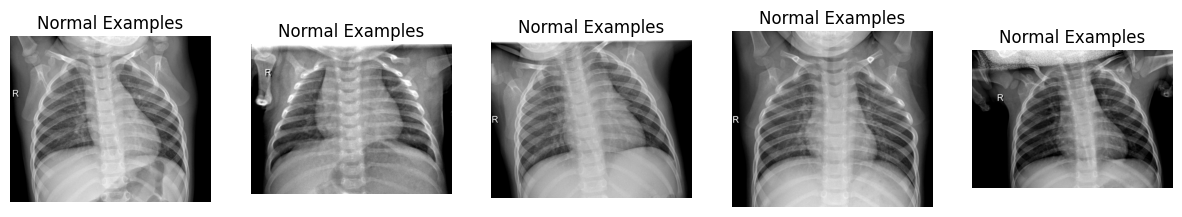

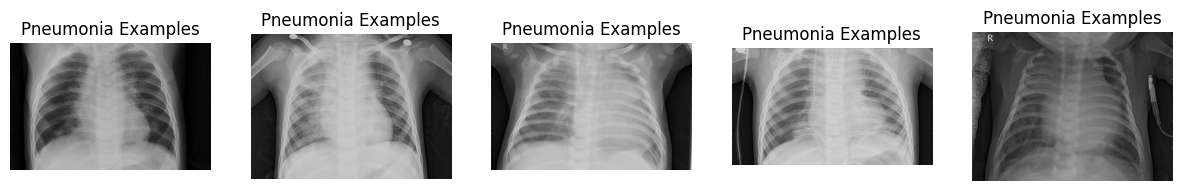

In [90]:


IMG_DIR = 'chest_xray_rebalanced/train/Normal'
SAMPLES = random.sample(os.listdir(IMG_DIR), 5)

plt.figure(figsize=(15,5))

for i, img_name in enumerate(SAMPLES):
    img = cv2.imread(os.path.join(IMG_DIR, img_name))
    plt.subplot(1, 5, i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Normal Examples')
    plt.axis('off')
plt.show

IMG_DIR = 'chest_xray_rebalanced/train/PNEUMONIA'
SAMPLES = random.sample(os.listdir(IMG_DIR), 5)

plt.figure(figsize=(15,5))

for i, img_name in enumerate(SAMPLES):
    img = cv2.imread(os.path.join(IMG_DIR, img_name))
    plt.subplot(1, 5, i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Pneumonia Examples')
    plt.axis('off')
plt.show

We can see that the dimensions vary. Before applying preprocessing we will inspect the images. We will check the dimensions, the color channels, the pixel intensities, the contrast, class leakage and check for corrupt images.

In [91]:


def analyze_dataset(BASE_DIR, classes = ['NORMAL', 'PNEUMONIA'], splits = ['train', 'test']):

    stats = defaultdict(list)
    corrupt_files = []

    for split in splits:
        for cls in classes:
            folder = BASE_DIR / split / cls
            print(f"Processing: {split}/{cls}")
            for file in folder.iterdir():
                try:
                    img = cv2.imread(str(file), cv2.IMREAD_UNCHANGED)
                    if img is None:
                        raise ValueError('Unreadable image')
                    h, w = img.shape[:2]
                    ch = 1 if len(img.shape) == 2 else img.shape[2]
                    stats['split'].append(split)
                    stats['class'].append(cls)
                    stats['filename'].append(str(file))
                    stats['height'].append(h)
                    stats['width'].append(w)
                    stats['channels'].append(ch)
                    stats['mean_pixel'].append(np.mean(img))
                    stats['std_pixel'].append(np.std(img))
                except (UnidentifiedImageError, ValueError, cv2.error):
                    corrupt_files.append(str(file))

    print('Total images scanned', len(stats['filename']))
    print("Corrupt images: ", len(corrupt_files))
    print("---------------------------------")
    print("Image Dimensions:")
    print(f"- Min Size: {min(stats['height'])} x {min(stats['width'])}")
    print(f"- Max Size: {max(stats['height'])} x {max(stats['width'])}")
    print(f"- Mean Size: {int(np.mean(stats['height']))} x {int(np.min(stats['width']))}")
    print("---------------------------------")
    print('Color Channels:')
    ch_count = {1: 'Grayscale', 3: 'RGB'}
    for ch in set(stats['channels']):
        print(f"- {ch_count.get(ch, f'{ch}-channel')}: {stats['channels'].count(ch)} images")
    print("---------------------------------")
    print("Contrast (std dev of pixel intensities):")
    for cls in classes:
        cls_std = [s for s, c in zip(stats['std_pixel'], stats['class']) if c == cls]
        print(f"- {cls}: mean={np.mean(cls_std):.2f}, range=({min(cls_std):.2f}–{max(cls_std):.2f})")
    print("---------------------------------")
    print("Showing pixel intensity histograms:")
    for cls in classes:
        cls_pixels = []
        for fname, c in zip(stats['filename'], stats['class']):
            if c == cls:
                img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    cls_pixels.append(img.flatten())
        pixels = np.concatenate(cls_pixels)
        plt.hist(pixels, bins=50, alpha=0.6, label=cls)
    plt.legend()
    plt.title("Pixel Intensity Histogram")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.show()

    return stats, corrupt_files




Processing: train/NORMAL
Processing: train/PNEUMONIA
Processing: test/NORMAL
Processing: test/PNEUMONIA
Total images scanned 5856
Corrupt images:  2
---------------------------------
Image Dimensions:
- Min Size: 127 x 384
- Max Size: 2713 x 2916
- Mean Size: 970 x 384
---------------------------------
Color Channels:
- Grayscale: 5573 images
- RGB: 283 images
---------------------------------
Contrast (std dev of pixel intensities):
- NORMAL: mean=61.27, range=(33.04–83.10)
- PNEUMONIA: mean=55.41, range=(20.42–87.48)
---------------------------------
Showing pixel intensity histograms:


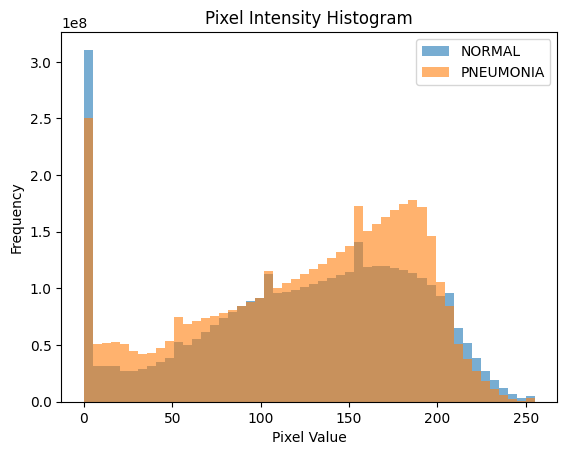

In [92]:

stats, corrupt_files = analyze_dataset(Path('chest_xray_rebalanced'))

In [93]:

for f in corrupt_files:
    print(f"  - {f}")

  - chest_xray_rebalanced/train/NORMAL/.DS_Store
  - chest_xray_rebalanced/train/PNEUMONIA/.DS_Store


In [94]:

dataset_root = Path("chest_xray_rebalanced")

ds_store_files = list(dataset_root.rglob('.DS_Store'))

for f in ds_store_files:
    print(f" Deleting: {f}")
    f.unlink()



 Deleting: chest_xray_rebalanced/train/PNEUMONIA/.DS_Store
 Deleting: chest_xray_rebalanced/train/NORMAL/.DS_Store


We deleted the .DS_Store files that are created by MacOS so they do not accidentaly get picked up and cause errors.

Our image dimensions show big variability so we will need to resize them. We will resize them to 128x128 so they can later be used for CNN as well. We will also convert all to grayscale. 
After that we will use them as flattened vectors for our models. We will have 128x128 = 16384 features.

Pneumonia images tend to be of lower contrast. We will apply CLAHE to normalize contrast.

Finally, we will normalize pixel values to [0,1]

In [95]:
def preprocess_image(path, target_size=(128,128), apply_clahe=False):
    """
    Preprocess the image.
    CLAHE contrast enhacement default set to False

    Returns:
        image (np.ndarray): Preproccesed image (grayscale, float32, normalized)
    """
    img = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
    if img is None:
        raise ValueError(f'Unable to read image {path}')
    
    #convert RBG to grayscale
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #apply CLAHE
    if apply_clahe:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img = clahe.apply(img)

    #resize to target size 
    img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)

    #normalize to [0,1]
    img = img.astype(np.float32) / 255.0

    return img

In [96]:
BASE_DIR = Path("chest_xray_rebalanced")
print(BASE_DIR)

chest_xray_rebalanced


In [97]:

output_base = Path("chest_xray_preprocessed_no_clahe")
splits = ['train', 'test']
targets = ['NORMAL', 'PNEUMONIA']
for split in splits:
    for target in targets:
        img_folder = BASE_DIR / split / target
        output_folder = output_base / split / target
        output_folder.mkdir(parents=True, exist_ok=True)
        
        for img_file in img_folder.glob("*.jpeg"):
            processed = preprocess_image(img_file, apply_clahe=False) #applied both true and false
            
            out_path = output_folder / (img_file.stem + ".png")
            cv2.imwrite(str(out_path), (processed * 255).astype("uint8"))


> **Note:**  
> In the final version of this notebook, for resources saving purposes, we train only on the **non-CLAHE** dataset, as CLAHE produced similar results. We opted to continue with the version that retained more natural contrast.  
> You can reproduce the CLAHE-based results by setting `apply_clahe = True` and re-running the notebook cells.


<function matplotlib.pyplot.show(close=None, block=None)>

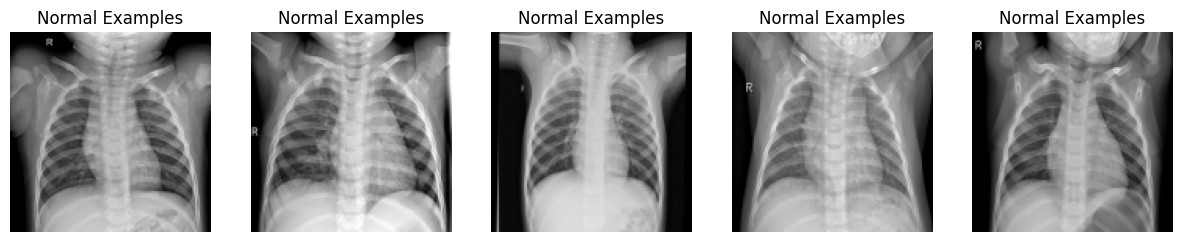

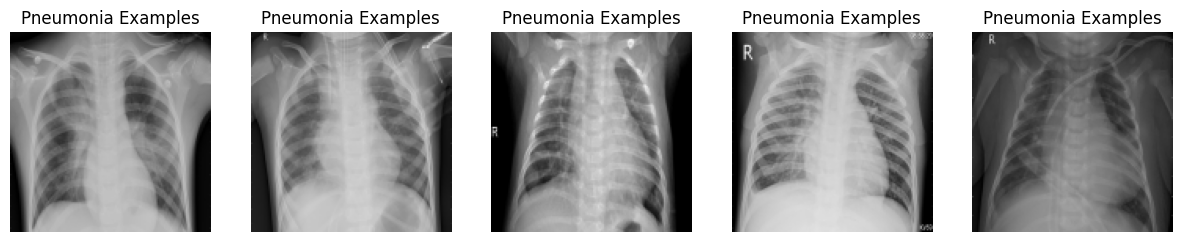

In [98]:


IMG_DIR = 'chest_xray_preprocessed_no_clahe/train/NORMAL'
SAMPLES = random.sample(os.listdir(IMG_DIR), 5)

plt.figure(figsize=(15,5))

for i, img_name in enumerate(SAMPLES):
    img = cv2.imread(os.path.join(IMG_DIR, img_name))
    plt.subplot(1, 5, i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Normal Examples')
    plt.axis('off')
plt.show

IMG_DIR = 'chest_xray_preprocessed_no_clahe/train/PNEUMONIA'
SAMPLES = random.sample(os.listdir(IMG_DIR), 5)

plt.figure(figsize=(15,5))

for i, img_name in enumerate(SAMPLES):
    img = cv2.imread(os.path.join(IMG_DIR, img_name))
    plt.subplot(1, 5, i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Pneumonia Examples')
    plt.axis('off')
plt.show

Processing: train/NORMAL
Processing: train/PNEUMONIA
Processing: test/NORMAL
Processing: test/PNEUMONIA
Total images scanned 5856
Corrupt images:  0
---------------------------------
Image Dimensions:
- Min Size: 128 x 128
- Max Size: 128 x 128
- Mean Size: 128 x 128
---------------------------------
Color Channels:
- Grayscale: 5856 images
---------------------------------
Contrast (std dev of pixel intensities):
- NORMAL: mean=60.70, range=(32.34–82.48)
- PNEUMONIA: mean=54.93, range=(19.74–87.19)
---------------------------------
Showing pixel intensity histograms:


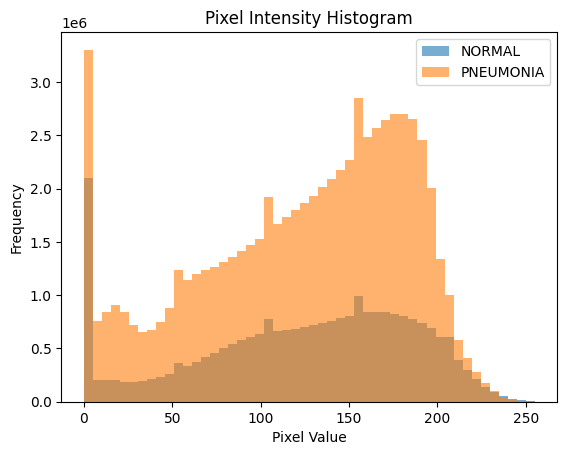

In [100]:
stats, corrupt_files = analyze_dataset(Path('chest_xray_preprocessed_no_clahe'))

With our dataset now cleaned, preprocessed, and properly structured, we are ready to begin model training. We will evaluate the following classical models:

- **Logistic Regression (LR)**
- **Support Vector Classifier (SVC)**
- **Random Forest (RF)**



1. **CLAHE Comparison**  
   Perform **5-fold cross-validation** on the training set with:
   - `CLAHE=True`
   - `CLAHE=False`  
   This helps us determine whether contrast enhancement improves generalization.

2. **Model Selection & Tuning**  
   - Select the best-performing model from the CV results above.
   - Perform **hyperparameter tuning** using cross-validation.

3. **Final Evaluation**  
   - Retrain the best model on the **entire training set**.
   - Evaluate on the **hold-out test set** to estimate unbiased, real-world performance.


In [101]:


def load_images_from_folder(folder_path, label, img_size=(128, 128)):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, img_size)
            img = img / 255.0  # normalize
            images.append(img)
            labels.append(label)
    return images, labels

def load_dataset(base_dir, data = 'train' ,img_size=(128, 128)):
    X, y = [], []
    for category, label in [('NORMAL', 0), ('PNEUMONIA', 1)]:
        folder = os.path.join(base_dir, data, category)
        imgs, lbls = load_images_from_folder(folder, label, img_size)
        X.extend(imgs)
        y.extend(lbls)
    return np.array(X), np.array(y)


base_path = 'chest_xray_preprocessed_no_clahe'

X, y = load_dataset(base_path, img_size=(128, 128))
X_test, y_test = load_dataset(base_path, data = 'test', img_size = (128,128) )

print(f"Loaded: {X.shape[0]} images — shape: {X.shape[1:]} — Labels: {np.bincount(y)}")
print(f"Loaded: {X_test.shape[0]} images — shape: {X_test.shape[1:]} — Labels: {np.bincount(y_test)}")


Loaded: 4976 images — shape: (128, 128) — Labels: [1345 3631]
Loaded: 880 images — shape: (128, 128) — Labels: [238 642]


In [102]:


# Flatten
X_flat = X.reshape(len(X), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)
X_test_scaled = scaler.transform(X_test_flat)


We scale the flattened image data before training classical machine learning models because algorithms like Logistic Regression and SVM are sensitive to feature magnitudes. Scaling ensures that all pixel features contribute equally, improving convergence and performance consistency.

In [103]:

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM (Linear Kernel)": SVC(kernel='linear'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\n--- {name} ---")
    scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='f1')
    print(f"CV F1-Score: {scores.mean():.4f} ± {scores.std():.4f}")



--- Logistic Regression ---
CV F1-Score: 0.9587 ± 0.0055

--- SVM (Linear Kernel) ---
CV F1-Score: 0.9565 ± 0.0047

--- Random Forest ---
CV F1-Score: 0.9610 ± 0.0034


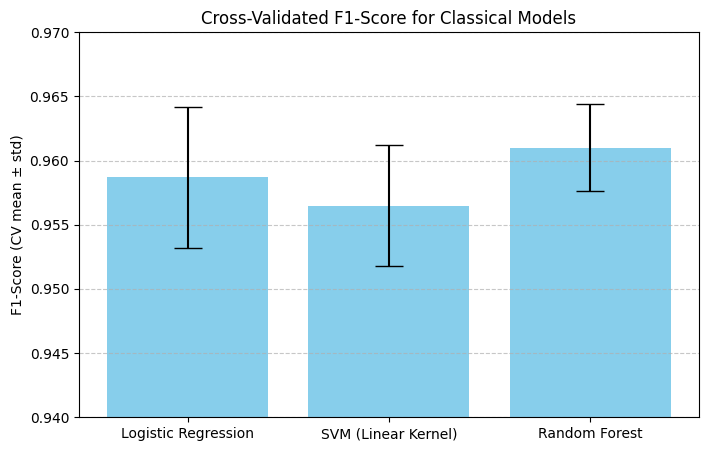

In [104]:
import matplotlib.pyplot as plt

model_names = ["Logistic Regression", "SVM (Linear Kernel)", "Random Forest"]
f1_means = [0.9587, 0.9565, 0.9610]
f1_stds = [0.0055, 0.0047, 0.0034]

plt.figure(figsize=(8, 5))
plt.bar(model_names, f1_means, yerr=f1_stds, capsize=10, color='skyblue')
plt.ylim(0.94, 0.97)
plt.ylabel("F1-Score (CV mean ± std)")
plt.title("Cross-Validated F1-Score for Classical Models")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [105]:


def objective(trial):
    # hyperparameters
    C = trial.suggest_float('C', 1e-4, 1e2, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])

    # Use liblinear for compatibility
    model = LogisticRegression(
        C=C,
        penalty=penalty,
        solver='liblinear',
        max_iter=1000
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='f1')
    
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("\n Best Parameters:", study.best_params)
print(" Best F1 Score: {:.4f}".format(study.best_value))


[I 2025-06-20 13:51:47,024] A new study created in memory with name: no-name-f8f31734-6ed0-4a65-bd2c-0891b8dbc942
[I 2025-06-20 13:56:42,439] Trial 0 finished with value: 0.9476294990025913 and parameters: {'C': 96.96010124769795, 'penalty': 'l2'}. Best is trial 0 with value: 0.9476294990025913.
[I 2025-06-20 13:56:54,662] Trial 1 finished with value: 0.8443486634192576 and parameters: {'C': 0.0014922045510247317, 'penalty': 'l1'}. Best is trial 0 with value: 0.9476294990025913.
[I 2025-06-20 14:02:16,406] Trial 2 finished with value: 0.9473199630681851 and parameters: {'C': 16.834336116800937, 'penalty': 'l2'}. Best is trial 0 with value: 0.9476294990025913.
[I 2025-06-20 14:09:27,152] Trial 3 finished with value: 0.9474682097696465 and parameters: {'C': 19.897670914057368, 'penalty': 'l2'}. Best is trial 0 with value: 0.9476294990025913.
[I 2025-06-20 14:09:51,779] Trial 4 finished with value: 0.9637129553163092 and parameters: {'C': 0.1868168161117671, 'penalty': 'l1'}. Best is tria


 Best Parameters: {'C': 0.10895963578644713, 'penalty': 'l1'}
 Best F1 Score: 0.9637


We now train the best performer on the full train set. After that, we will test on the holdout set for the evaluation report.

In [ ]:
# Train best model on full dataset
# best params are LogisticRegression(
# C=0.10895963578644713, max_iter=1000, penalty='l1',
# solver='liblinear')
best_params = study.best_params
final_model = LogisticRegression(
    **best_params,
    solver='liblinear',
    max_iter=1000
)
final_model.fit(X_scaled, y)


LogisticRegression(C=0.10895963578644713, max_iter=1000, penalty='l1',
                   solver='liblinear')

In [107]:
y_test_pred = final_model.predict(X_test_scaled)

from sklearn.metrics import classification_report, confusion_matrix
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


Test Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.84      0.88       238
           1       0.94      0.98      0.96       642

    accuracy                           0.94       880
   macro avg       0.94      0.91      0.92       880
weighted avg       0.94      0.94      0.94       880

Confusion Matrix:
 [[200  38]
 [ 15 627]]


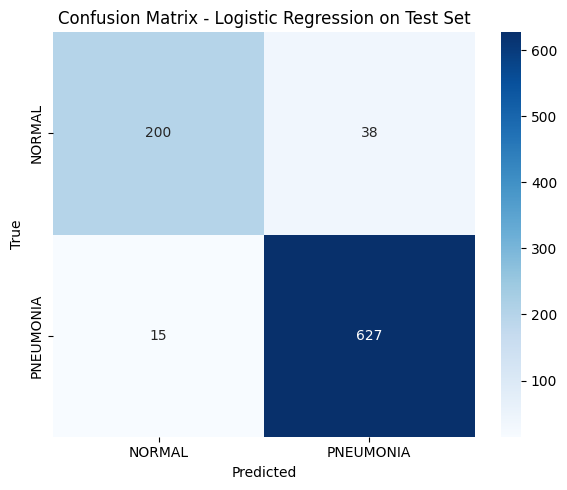

In [108]:
cm = confusion_matrix(y_test, y_test_pred)
labels = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Logistic Regression on Test Set")
plt.tight_layout()
plt.show()



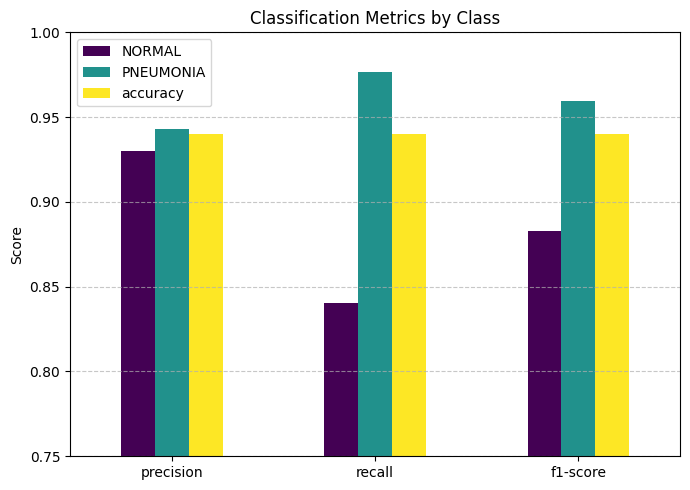

In [109]:
report = classification_report(y_test, y_test_pred, target_names=labels, output_dict=True)
df = pd.DataFrame(report).iloc[:3, :3]  # Only NORMAL & PNEUMONIA rows

df.plot(kind='bar', figsize=(7, 5), colormap='viridis')
plt.title("Classification Metrics by Class")
plt.ylabel("Score")
plt.ylim(0.75, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


We will now proceed with question b) 

First, using a custom made CNN.

We load our dataset and reshape it as CNNs expect a 4D input: (batch_size, height, width, channels). We then build the CNN and train it on our train set using a 80/20 split with train_test_split. Finally we validate using the test holdout set.



In [138]:
X, y = load_dataset(base_path, img_size=(128, 128))
print(f"Loaded: {X.shape[0]} images — shape: {X.shape[1:]} — Labels: {np.bincount(y)}")


Loaded: 4976 images — shape: (128, 128) — Labels: [1345 3631]


In [139]:

X = X.reshape(-1, 128, 128, 1).astype('float32')
y = y.astype('int')


In [140]:


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [141]:


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])


/opt/anaconda3/envs/ML_Test/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [142]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val))


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 110ms/step - accuracy: 0.8602 - loss: 0.4246 - val_accuracy: 0.7299 - val_loss: 0.6282
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9493 - loss: 0.1346 - val_accuracy: 0.7299 - val_loss: 0.7877
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 0.9622 - loss: 0.1086 - val_accuracy: 0.7299 - val_loss: 1.5175
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step - accuracy: 0.9704 - loss: 0.0917 - val_accuracy: 0.8705 - val_loss: 0.3228
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 184ms/step - accuracy: 0.9752 - loss: 0.0741 - val_accuracy: 0.9588 - val_loss: 0.1047
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 280ms/step - accuracy: 0.9765 - loss: 0.0555 - val_accuracy: 0.9639 - val_loss: 0.1006
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 277ms/step - accuracy: 0.9796 - loss: 0.0550 - val_accuracy: 0.9508 - val_loss: 0.1513
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 25s 199ms/step - accuracy: 0.9855 - loss: 0

In [143]:
X, y = load_dataset(base_path, img_size=(128, 128), data = 'test')
print(f"Loaded: {X.shape[0]} images — shape: {X.shape[1:]} — Labels: {np.bincount(y)}")


X = X.reshape(-1, 128, 128, 1).astype('float32')
y = y.astype('int')


y_pred = (model.predict(X) > 0.5).astype('int').flatten()
print("Confusion Matrix:\n", confusion_matrix(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred))


Loaded: 880 images — shape: (128, 128) — Labels: [238 642]
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Confusion Matrix:
 [[216  22]
 [ 12 630]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93       238
           1       0.97      0.98      0.97       642

    accuracy                           0.96       880
   macro avg       0.96      0.94      0.95       880
weighted avg       0.96      0.96      0.96       880



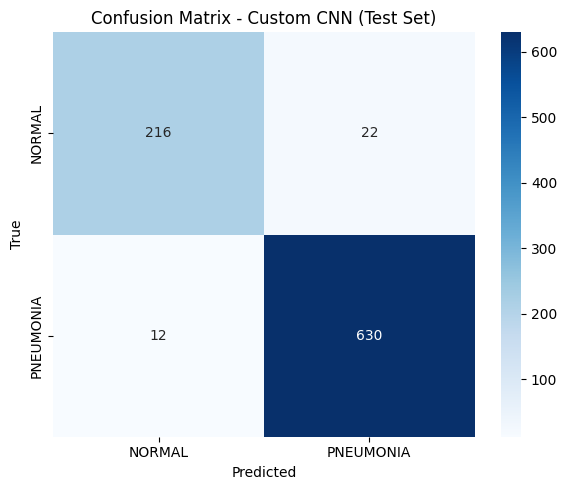

In [144]:
cm = confusion_matrix(y, y_pred)
labels = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Custom CNN (Test Set)")
plt.tight_layout()
plt.show()


Now we will also try transfer learning with DenseNet121 which is state of the art for X-ray medical image classification. We load again the dataset and convert back to 3-channel RGB and resize to 224x224 as this is the expected input for DenseNet121

In [145]:
X_resized = np.array([cv2.resize(img, (224,224)) for img in X])
X_rgb = np.repeat(X_resized[..., np.newaxis], 3, axis=-1).astype('float32')

In [146]:
print(f"Loaded: {X_rgb.shape[0]} images — shape: {X_rgb.shape[1:]} — Labels: {np.bincount(y)}")


Loaded: 880 images — shape: (224, 224, 3) — Labels: [238 642]


In [147]:
X_train, X_val, y_train, y_val = train_test_split(X_rgb, y, test_size=0.2, stratify=y, random_state=42)


In [148]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)



In [149]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data = (X_val, y_val)
)


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.6350 - loss: 0.7055 - val_accuracy: 0.7273 - val_loss: 0.5754
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7064 - loss: 0.6150 - val_accuracy: 0.7614 - val_loss: 0.4718
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7842 - loss: 0.4978 - val_accuracy: 0.7784 - val_loss: 0.4167
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.7733 - loss: 0.4802 - val_accuracy: 0.8409 - val_loss: 0.3697
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.8114 - loss: 0.4287 - val_accuracy: 0.8920 - val_loss: 0.3335
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8080 - loss: 0.4254 - val_accuracy: 0.8807 - val_loss: 0.3097
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.8666 - loss: 0.3432 - val_accuracy: 0.9148 - val_loss: 0.2863
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.8574 - loss: 0.3642 - val_accuracy: 0.9205 - val_loss:

In [150]:
X, y = load_dataset(base_path, img_size=(128, 128), data = 'test')
print(f"Loaded: {X.shape[0]} images — shape: {X.shape[1:]} — Labels: {np.bincount(y)}")


X_resized = np.array([cv2.resize(img, (224,224)) for img in X])
X_rgb = np.repeat(X_resized[..., np.newaxis], 3, axis=-1).astype('float32')
y = y.astype('int')
print(f"Loaded: {X_rgb.shape[0]} images — shape: {X_rgb.shape[1:]} — Labels: {np.bincount(y)}")


y_pred = (model.predict(X_rgb) > 0.5).astype('int').flatten()
print("Confusion Matrix:\n", confusion_matrix(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred))

Loaded: 880 images — shape: (128, 128) — Labels: [238 642]
Loaded: 880 images — shape: (224, 224, 3) — Labels: [238 642]
28/28 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step
Confusion Matrix:
 [[202  36]
 [ 32 610]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.85      0.86       238
           1       0.94      0.95      0.95       642

    accuracy                           0.92       880
   macro avg       0.90      0.90      0.90       880
weighted avg       0.92      0.92      0.92       880



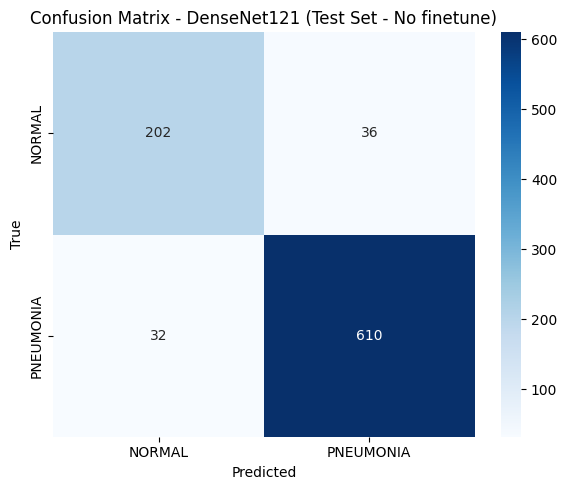

In [151]:
cm = confusion_matrix(y, y_pred)
labels = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - DenseNet121 (Test Set - No finetune)")
plt.tight_layout()
plt.show()


Finally, we will also try finetuning the model. Initially we freeze the model and train the classification head and after some epochs we will unfreeze part of the layers to train them, with a lower learning rate to prevent large weight updates. 

In [152]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  #model initially frozen

# classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), batch_size=32)


Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.6454 - loss: 0.7164 - val_accuracy: 0.7273 - val_loss: 0.5495
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.7020 - loss: 0.6136 - val_accuracy: 0.7500 - val_loss: 0.4658
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7172 - loss: 0.5528 - val_accuracy: 0.8011 - val_loss: 0.4027
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7618 - loss: 0.4836 - val_accuracy: 0.9034 - val_loss: 0.3571
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8129 - loss: 0.4255 - val_accuracy: 0.9091 - val_loss: 0.3151


In [153]:
for layer in base_model.layers[:100]:
    layer.trainable = False
for layer in base_model.layers[100:]:
    layer.trainable = True


In [154]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [155]:
history_finetune = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_val, y_val)
)


Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.7538 - loss: 0.5125 - val_accuracy: 0.9318 - val_loss: 0.2777
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.8519 - loss: 0.3601 - val_accuracy: 0.9375 - val_loss: 0.2615
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - accuracy: 0.8853 - loss: 0.2814 - val_accuracy: 0.9375 - val_loss: 0.2473
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.9319 - loss: 0.1973 - val_accuracy: 0.9375 - val_loss: 0.2306
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.9346 - loss: 0.1892 - val_accuracy: 0.9375 - val_loss: 0.2192


In [156]:
X, y = load_dataset(base_path, img_size=(128, 128), data = 'test')
print(f"Loaded: {X.shape[0]} images — shape: {X.shape[1:]} — Labels: {np.bincount(y)}")


X_resized = np.array([cv2.resize(img, (224,224)) for img in X])
X_rgb = np.repeat(X_resized[..., np.newaxis], 3, axis=-1).astype('float32')
y = y.astype('int')
print(f"Loaded: {X_rgb.shape[0]} images — shape: {X_rgb.shape[1:]} — Labels: {np.bincount(y)}")


y_pred = (model.predict(X_rgb) > 0.5).astype('int').flatten()
print("Confusion Matrix:\n", confusion_matrix(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred))

Loaded: 880 images — shape: (128, 128) — Labels: [238 642]
Loaded: 880 images — shape: (224, 224, 3) — Labels: [238 642]
28/28 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step 
Confusion Matrix:
 [[230   8]
 [ 48 594]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.97      0.89       238
           1       0.99      0.93      0.95       642

    accuracy                           0.94       880
   macro avg       0.91      0.95      0.92       880
weighted avg       0.94      0.94      0.94       880



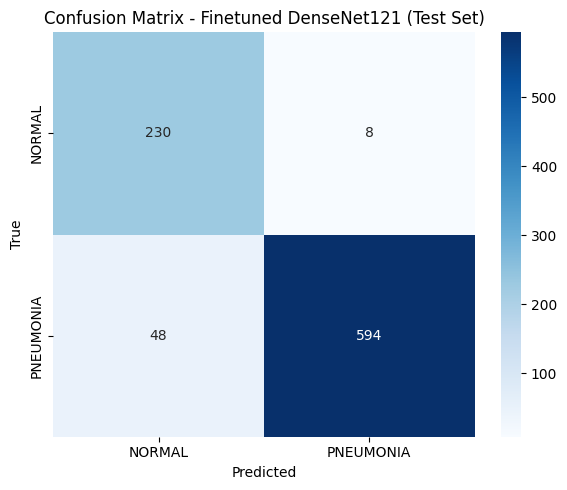

In [157]:
cm = confusion_matrix(y, y_pred)
labels = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Finetuned DenseNet121 (Test Set)")
plt.tight_layout()
plt.show()


We evaluated the three deep learning approaches for binary pneumonia detection: a custom-built CNN, a DenseNet121 model with frozen pretrained layers, and a fine-tuned DenseNet121. The custom CNN, tailored to the input resolution and trained from scratch, achieved strong performance with 96% accuracy, an F1-score of 0.93 for NORMAL and 0.97 for PNEUMONIA. The frozen DenseNet121, using ImageNet-pretrained weights without adaptation, performed comparably but worse (92% accuracy) and  underperformed on both classes (F1-score: 0.9). After fine-tuning DenseNet121, we observed improved generalization: accuracy increased to 94%, and the F1-score for NORMAL rose to 0.89. This confirms that fine-tuning pretrained models allows them to better capture domain-specific patterns in chest X-ray images, especially in limited-data settings. However, our CNN performed better than DenseNet probably due to the large number of the DenseNet parameters (8 million) given our dataset is limited to train them efficiently.

We will now compare all the models used on the dataset.

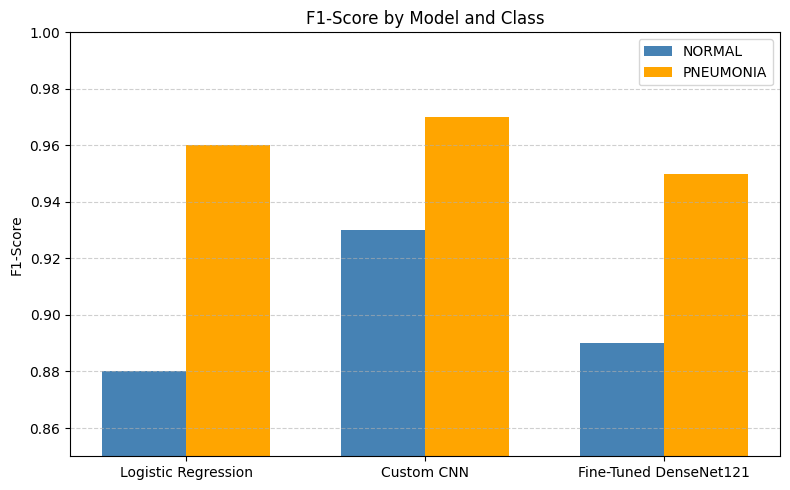

In [158]:

models = ["Logistic Regression", "Custom CNN", "Fine-Tuned DenseNet121"]

# F1-scores for each class
f1_scores_normal = [0.88, 0.93, 0.89]      # Class 0: NORMAL
f1_scores_pneumonia = [0.96, 0.97, 0.95]   # Class 1: PNEUMONIA

# Bar positions
x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, f1_scores_normal, width, label='NORMAL', color='steelblue')
plt.bar(x + width/2, f1_scores_pneumonia, width, label='PNEUMONIA', color='orange')
plt.ylabel("F1-Score")
plt.ylim(0.85, 1.0)
plt.title("F1-Score by Model and Class")
plt.xticks(x, models)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


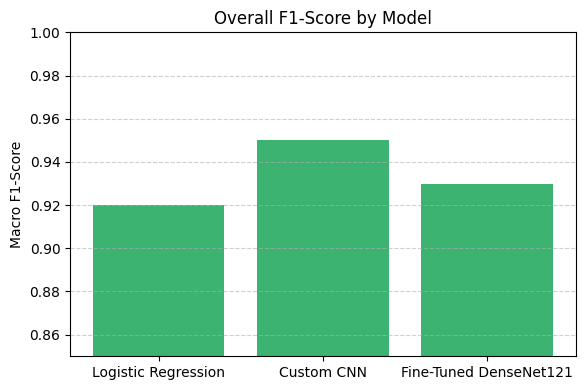

In [159]:
models = ["Logistic Regression", "Custom CNN", "Fine-Tuned DenseNet121"]
macro_f1 = [0.92, 0.95, 0.93]  # macro avg F1s

plt.figure(figsize=(6, 4))
plt.bar(models, macro_f1, color='mediumseagreen')
plt.ylabel("Macro F1-Score")
plt.title("Overall F1-Score by Model")
plt.ylim(0.85, 1.00)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


We see that despite the problems with the limited data set and despite excessive hyperparameter tuning on the LR compared to how much we tuned the neural networks, both CNNs outperform our classical machine learning method.

## Discussion

In this exercise, we developed and evaluated multiple machine learning and deep learning approaches for pneumonia detection from chest X-ray images downloaded from Kaggle. We decided to compare the models focusing on F1-score due to the dataset's class imbalance.

Classical models (Logistic Regression, SVM, Random Forest) performed surprisingly well given the raw pixel-based feature representation. Among them, Random Forest achieved the highest F1-score (0.961 ± 0.0034), with relatively consistent results across validation folds. However, given that the LR model could be trained much faster and also is generally more interpretable than RFs we decided to tune the LR. Our hyperparameter tuned LR achieved a macro F1-score of 0.92 with better performance on PNEUMONIA images which was expected given their abundancy in the dataset.

The custom CNN, designed from scratch and trained on grayscale 128×128 images, demonstrated a solid balance between accuracy and simplicity. It achieved an overall accuracy of 96% and F1-scores of 0.93 and 0.97 for NORMAL and PNEUMONIA, respectively, confirming that even lightweight architectures can perform competitively when tailored to the dataset.

We then explored transfer learning using DenseNet121 pretrained on ImageNet. When only the top classification head was trained (with base layers frozen), the model’s performance was comparable to the CNN, but slightly lower. After fine tuning the model it performed better than before, but still worse than our small custom CNN, probably due to the huge number of parameters of DenseNet compared to our limited dataset (~5000 samples). However, it still was really fast to train and use and better performing than the classical ML methods.

In summary, while classical models provide a strong and interpretable baseline, deep learning models  offer superior and more balanced performance in complex tasks like medical image classification.